# Example 3: Normalize data to MNI template

This example covers the normalization of data. Some people prefer to normalize the data during the preprocessing, just before smoothing. I prefer to do the 1st-level analysis completely in subject space and only normalize the contrasts for the 2nd-level analysis. But both approaches are fine.

For the current example, we will take the computed 1st-level contrasts from the previous experiment (again once done with fwhm=4mm and fwhm=8mm) and normalize them into MNI-space. To show two different approaches, we will do the normalization once with ANTs and once with SPM.

## Normalization with ANTs

The normalization with ANTs requires that you first compute the transformation matrix that would bring the anatomical images of each subject into template space. Depending on your system this might take a few hours per subject. To facilitate this step, the transformation matrix is already computed for the T1 images.

The data for it can be found under:

In [ ]:
!ls /data/ds000114/derivatives/fmriprep/sub-*/anat/*h5

/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-03/anat/sub-03_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-04/anat/sub-04_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-05/anat/sub-05_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-06/anat/sub-06_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-07/anat/sub-07_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-08/anat/sub-08_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-09/anat/sub-09_t1w_space-mni152nlin2009casym_warp.h5
/data/ds000114/derivatives/fmriprep/sub-10/anat/sub-10_t1w_space-mni152nlin2009casym_warp.h5


If you want to compute the transformation matrix yourself, either use [fmriprep](http://fmriprep.readthedocs.io), as in our example dataset.

Alternatively, you can also create a ANTS registration pipeline yourself. An example of such a pipeline would look as follows (**note, that you can load the script to see the workflow, but you don't have to run it, we will NOT use the output of the workflow in this nothebook**):

In [ ]:
%load scripts/ANTS_registration.py

**Now, let's start with the ANTs normalization workflow!**

## Imports (ANTs)

First, we need to import all modules we later want to use.

In [ ]:
from os.path import join as opj
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.fsl import Info

## Experiment parameters (ANTs)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. And remember that we decided to run the group analysis without subject ``sub-01``, ``sub-06`` and ``sub-10`` because they are left handed (see [this section](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Special-case)).

In [ ]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers (remember we use only right handed subjects)
subject_list = ['sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-07', 'sub-08', 'sub-09']

# task name
task_name = "fingerfootlips"

# Smoothing widths used during preprocessing
fwhm = [4, 8]

# Template to normalize to
template = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

**Note** that the **``template``** file might not be in your ``data``  directory. To get ``mni_icbm152_nlin_asym_09c``, either download it from this [website](https://files.osf.io/v1/resources/fvuh8/providers/osfstorage/580705089ad5a101f17944a9), unpack it and move it to ``/data/ds000114/derivatives/fmriprep/`` or run the following command in a cell:

```bash
%%bash
curl -L https://files.osf.io/v1/resources/fvuh8/providers/osfstorage/580705089ad5a101f17944a9 \
     -o /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz
     
tar xf /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz \
    -C /data/ds000114/derivatives/fmriprep/.
    
rm /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz
```

## Specify Nodes (ANTs)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [ ]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

## Specify input & output stream (ANTs)

Specify where the input data can be found & where and how to save the output data.

In [ ]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        '{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'transform': opj('/data/ds000114/derivatives/fmriprep/', '{subject_id}', 'anat',
                              '{subject_id}_t1w_space-mni152nlin2009casym_warp.h5')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
subjFolders += [('_apply2con%s/' % (i), '') for i in range(9)] # number of contrast used in 1stlevel an.
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (ANTs)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [ ]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('fwhm_id', 'fwhm_id')]),
                  (selectfiles, apply2con, [('con', 'input_image'),
                                            ('transform', 'transforms')]),
                  (apply2con, datasink, [('output_image', 'norm_ants.@con')]),
                  ])

## Visualize the workflow (ANTs)

It always helps to visualize your workflow.

170903-22:25:26,286 workflow INFO:
	 Generated workflow graph: /output/workingdir/antsflow/graph.dot.png (graph2use=colored, simple_form=True).


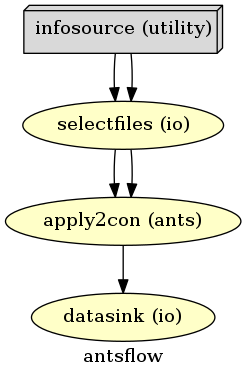

In [ ]:
# Create ANTs normalization graph
antsflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(antsflow.base_dir, 'antsflow', 'graph.dot.png'))

##  Run the Workflow (ANTs)

Now that everything is ready, we can run the ANTs normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [ ]:
antsflow.run('MultiProc', plugin_args={'n_procs': 4})

# Normalization with SPM12

The normalization with SPM12 is rather straight forward. The only thing we need to do is run the Normalize12 module. **So let's start!**

## Imports (SPM12)

First, we need to import all modules we later want to use.

In [ ]:
from os.path import join as opj
from nipype.interfaces.spm import Normalize12
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype.pipeline.engine import Workflow, Node

## Experiment parameters (SPM12)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. And remember that we decided to run the group analysis without subject ``sub-01``, ``sub-06`` and ``sub-10`` because they are left handed (see [this section](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Special-case)).

In [ ]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-07', 'sub-08', 'sub-09']

# task name
task_name = "fingerfootlips"

# Smoothing withds used during preprocessing
fwhm = [4, 8]

template = '/opt/spm12/spm12_mcr/spm/spm12/tpm/TPM.nii'

## Specify Nodes (SPM12)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [ ]:
# Gunzip - unzip the anatomical image
gunzip = Node(Gunzip(), name="gunzip")

# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[1, 1, 1]),
                 name="normalize")

## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [ ]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        '{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'anat': opj('/data/ds000114/derivatives', 'fmriprep', '{subject_id}', 
                         'anat', '{subject_id}_t1w_preproc.nii.gz')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [ ]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('fwhm_id', 'fwhm_id')]),
                 (selectfiles, normalize, [('con', 'apply_to_files')]),
                 (selectfiles, gunzip, [('anat', 'in_file')]),
                 (gunzip, normalize, [('out_file', 'image_to_align')]),
                 (normalize, datasink, [('normalized_files', 'norm_spm.@files'),
                                        ('normalized_image', 'norm_spm.@image'),
                                        ]),
                 ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

170903-22:25:34,824 workflow INFO:
	 Generated workflow graph: /output/workingdir/spmflow/graph.dot.png (graph2use=colored, simple_form=True).


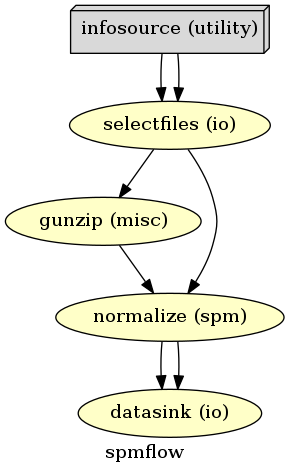

In [ ]:
# Create SPM normalization graph
spmflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(spmflow.base_dir, 'spmflow', 'graph.dot.png'))

##  Run the Workflow (SPM12)

Now that everything is ready, we can run the SPM normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [ ]:
spmflow.run('MultiProc', plugin_args={'n_procs': 4})

# Comparison between ANTs and SPM normalization

Now that we ran the normalization with ANTs and SPM, let us compare their output.

In [ ]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

First, let's compare the normalization of the **anatomical** images:

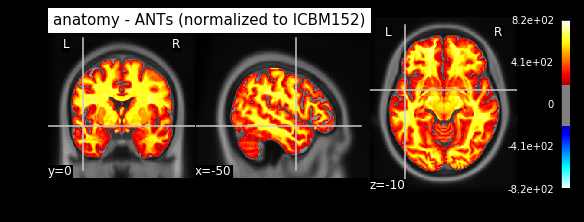

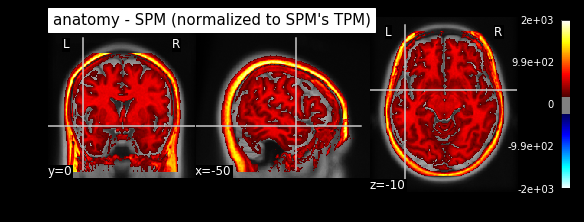

In [ ]:
plot_stat_map(
    '/data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_space-mni152nlin2009casym_preproc.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))
plot_stat_map(
    '/output/datasink/norm_spm/sub-02_fwhm4/wsub-02_t1w_preproc.nii',
    title='anatomy - SPM (normalized to SPM\'s TPM)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))

And what about the **contrast** images for **Finger > others**?

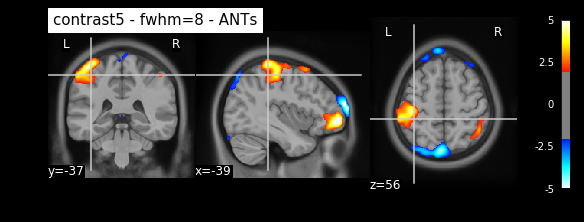

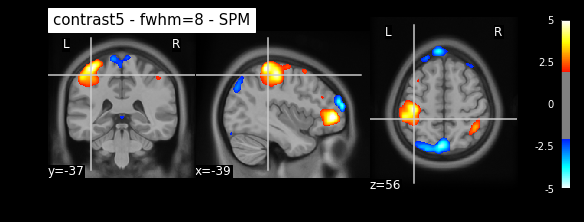

In [ ]:
plot_stat_map(
    '/output/datasink/norm_ants/sub-02_fwhm8/con_0005_trans.nii', title='contrast5 - fwhm=8 - ANTs',
    bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56))
plot_stat_map(
    '/output/datasink/norm_spm/sub-02_fwhm8/wcon_0005.nii', title='contrast5 - fwhm=8 - SPM',
    bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56))

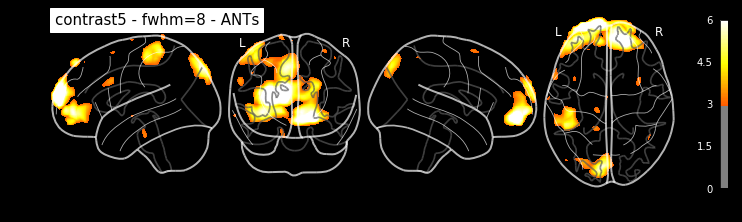

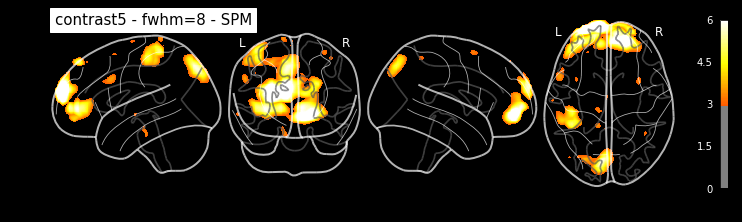

In [ ]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/output/datasink/norm_ants/sub-02_fwhm8/con_0005_trans.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=6, title='contrast5 - fwhm=8 - ANTs')
plot_glass_brain(
    '/output/datasink/norm_spm/sub-02_fwhm8/wcon_0005.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=6, title='contrast5 - fwhm=8 - SPM')